In [1]:
import matplotlib.pyplot as plt
import numpy as np

import pylops
import pyproximal
import segyio
from scipy.signal import filtfilt, convolve
from scipy.io import loadmat

import warnings
warnings.filterwarnings('ignore')
 
np.random.seed(1)

In [2]:
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

## Proximal Solvers
### ... and their application to geoscience problems

## Motivation

Gradient-based optimization

$$
\underset{\mathbf{m}} {\mathrm{argmin}} \quad \frac{1}{2} ||\mathbf{d} - \mathbf{Gm}||_2^2 + \alpha ||\mathbf{m}||_2^2 + \beta ||\nabla_x\mathbf{m}||_2^2 + \gamma ||\nabla_z\mathbf{m}||_2^2 \qquad \textrm{L2-regularized (linear)}
$$

and 

$$
\underset{\mathbf{m}} {\mathrm{argmin}} \quad \frac{1}{2} ||\mathbf{d} - g(\mathbf{m})||_2^2 + \alpha ||\mathbf{m}||_2^2 + \beta ||\nabla_x\mathbf{m}||_2^2 + \gamma ||\nabla_z\mathbf{m}||_2^2 \qquad \textrm{L2-regularized (nonlinear)}
$$

## Motivation

Proximal-based optimization

$$
\underset{\mathbf{m}} {\mathrm{argmin}} \quad \frac{1}{2} ||\mathbf{d} - \mathbf{Gm}||_2^2 + \alpha ||\mathbf{m}||_1 \qquad \textrm{L1-regularized / Sparse inversion}
$$

and 

$$
\underset{\mathbf{m}} {\mathrm{argmin}} \quad \frac{1}{2} ||\mathbf{d} - \mathbf{Gm}||_2^2 + \alpha ||\mathbf{M}||_* \qquad \textrm{Low-rank matrix approximation} 
$$

and 

$$
\underset{\mathbf{m}} {\mathrm{argmin}} \quad \frac{1}{2} ||\mathbf{d} - \mathbf{Gm}||_2^2 + \alpha TV(\mathbf{m}) \qquad \textrm{TV-regularized inversion} 
$$

and 

$$
\underset{\mathbf{m} \in C} {\mathrm{argmin}} \quad \frac{1}{2} ||\mathbf{d} - \mathbf{Gm}||_2^2  \qquad \textrm{Constrained inversion}
$$

## Motivation

Nuclear norm:
    
$$
(||\cdot||_*=\sum_i \sigma_i)
$$

Total-variation norm

$$
TV=\sqrt{\partial \mathbf{m}_x^2 + \partial \mathbf{m}_z^2}
$$


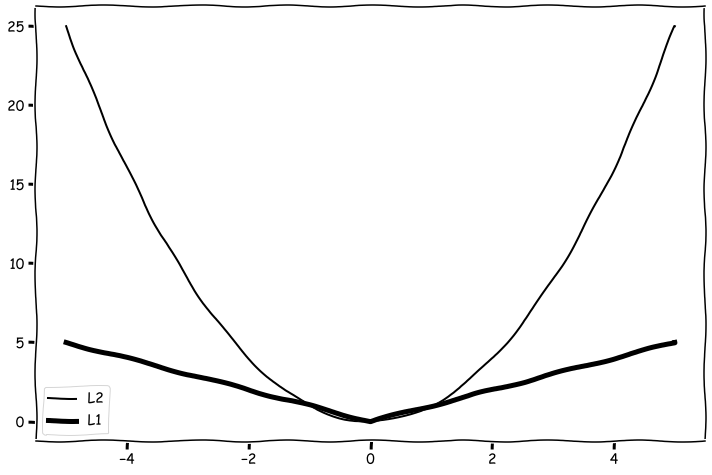

In [3]:
with plt.xkcd():
    plt.figure(figsize=(12, 8))
    x = np.arange(-5, 5.01, 0.01)
    plt.plot(x, x**2, 'k', lw=2, label='L2')
    plt.plot(x, np.abs(x), 'k', lw=5, label='L1')
    plt.legend()

## Denoising

We want to reconstruct a blocky 1D signal from noisy measuments:
    
$$
\underset{\mathbf{m}} {\mathrm{argmin}} \quad \frac{1}{2} ||\mathbf{d} - \mathbf{m}||_2^2 + \alpha ||\nabla^2 \mathbf{m}||_2^2
$$

or 

$$
\underset{\mathbf{m}} {\mathrm{argmin}} \quad \frac{1}{2} ||\mathbf{d} - \mathbf{m}||_2^2 + \alpha ||\nabla\mathbf{m}||_1
$$

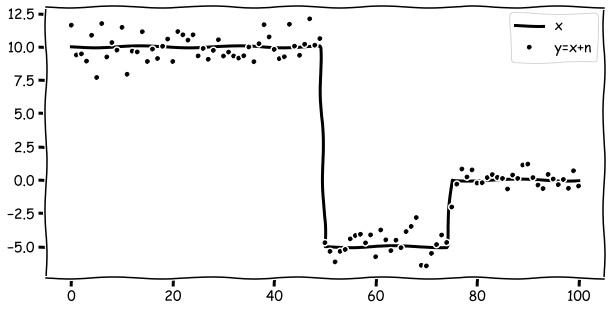

In [4]:
import pylops
import pyproximal

nx = 101
x = np.zeros(nx)
x[: nx // 2] = 10
x[nx // 2 : 3 * nx // 4] = -5

Iop = pylops.Identity(nx)

n = np.random.normal(0, 1, nx)
y = Iop * x + n

with plt.xkcd():
    plt.figure(figsize=(10, 5))
    plt.plot(x, "k", lw=3, label="x")
    plt.plot(y, ".k", label="y=x+n")
    plt.legend();

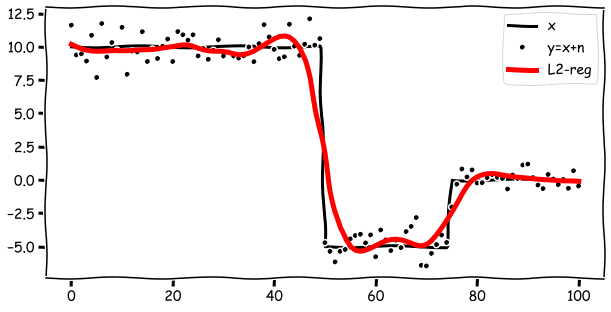

In [5]:
D2op = pylops.SecondDerivative(nx, edge=True)
alpha = 1e2

xinv = pylops.optimization.leastsquares.RegularizedInversion(
    Iop, [D2op], y, epsRs=[np.sqrt(alpha / 2)], **dict(iter_lim=30))

with plt.xkcd():
    plt.figure(figsize=(10, 5))
    plt.plot(x, "k", lw=3, label="x")
    plt.plot(y, ".k", label="y=x+n")
    plt.plot(xinv, "r", lw=5, label="L2-reg")
    plt.legend();

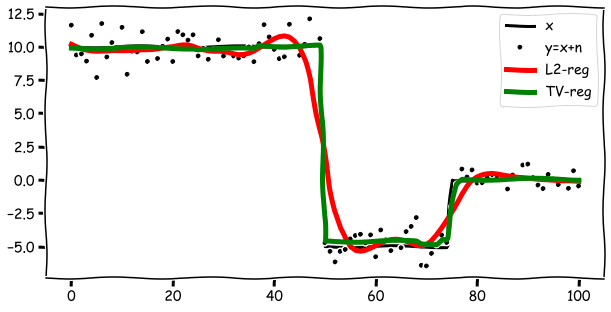

In [6]:
D2op = pylops.FirstDerivative(nx, edge=True, kind='backward')
f = pyproximal.L2(Iop, y, niter=20)
g = pyproximal.L1(2.)

L = (D2op.H @ D2op).eigs(1)[0].real
tau = 1.
mu = tau / L
xtv = pyproximal.optimization.primal.LinearizedADMM(f, g, D2op, np.zeros_like(x),
                                                    tau, mu, niter=500, show=False)[0]

with plt.xkcd():
    plt.figure(figsize=(10, 5))
    plt.plot(x, "k", lw=3, label="x")
    plt.plot(y, ".k", label="y=x+n")
    plt.plot(xinv, "r", lw=5, label="L2-reg")
    plt.plot(xtv, "g", lw=5, label="TV-reg")
    plt.legend();

## Optimizing convex functionals

Let's define the general case

$$
\underset{\mathbf{m}} {\mathrm{argmin}} \; f(\mathbf{m})
$$

where $f$ is a **smooth** convex function (e.g. L2 norm).

This can be solved via the **Gradient Descent** algorithm:

$$
\mathbf{m}_{k+1} = \mathbf{m}_k - \alpha \nabla f(\mathbf{m}_k)
$$

which we can rewrite as a Fixed-Point algorithm defining $\mathcal{T}(\mathbf{m})=I- \alpha \nabla f(\mathbf{m})$:

$$
\mathbf{m}_{k+1} = \mathcal{T}(\mathbf{m}_k)
$$

and when the fixed-point $\mathbf{m}_*$ is reached we have found the solution!

## Optimizing convex functionals

Let's define the general case

$$
\underset{\mathbf{m}} {\mathrm{argmin}} \; f(\mathbf{m})
$$

where $f$ is now a **non-smooth** convex function (e.g. L1 norm).

This can be solved via the **Proximal Point** algorithm:

$$
\mathbf{m}_{k+1} = prox_{\tau f} (\mathbf{m}_k) 
$$

Let's see how this works with a simple example:

$$
\underset{\mathbf{m}} {\mathrm{argmin}} \; ||\mathbf{m}||_1
$$

In [7]:
def callback(x):
    xhist.append(x)

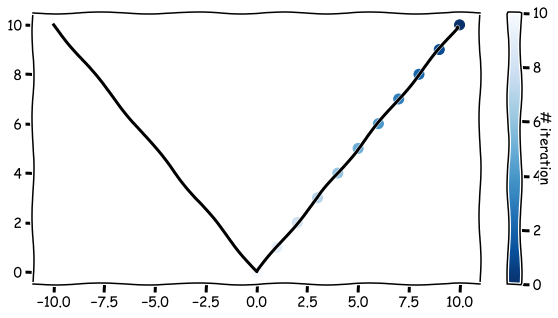

In [8]:
f = pyproximal.L1()
x0 = np.array([10,])

xhist = [x0, ]
x = pyproximal.optimization.primal.ProximalPoint(f, x0, tau, niter=20, callback=lambda x: callback(x))

with plt.xkcd():
    plt.figure(figsize=(10, 5))
    plt.plot(np.arange(-10, 10, 0.1), np.abs(np.arange(-10, 10, 0.1)), "k", lw=3, label="x")
    plt.scatter(xhist, np.abs(xhist), c=np.arange(21), s=100, cmap='Blues_r', vmin=0, vmax=10);
    cbar = plt.colorbar()
    cbar.ax.set_ylabel('# iteration', rotation=270);

## Proximal operator

$$
prox_{\tau f} (\mathbf{v}) = (I+ \tau \partial f)^{-1}(\mathbf{x})  = \underset{\mathbf{m}} {\mathrm{argmin}} \quad f(\mathbf{m}) + \frac{1}{2\tau}||\mathbf{m}-\mathbf{v}||_2^2
$$

<img src="Figs/ProximalOp.png" width="500" align="center">

Source: Parikh N., Proximal Algorithms.

## Proximal operator

An inverse problem at every step of the iterative scheme... bahhh!!

Luckily many proximal operators have **closed-form** solution:

$$
\text{Squared L2:} \;
prox_{\tau ||\cdot||_2^2} (\mathbf{v})  = \underset{\mathbf{m}} {\mathrm{argmin}} \quad ||\mathbf{m}||_2^2 + \frac{1}{2\tau}||\mathbf{m}-\mathbf{v}||_2^2 = \frac{\mathbf{v}}{1+\tau}
$$

$$
\text{L1:} \;prox_{\tau ||\cdot||_1} (\mathbf{v})  = \underset{\mathbf{m}} {\mathrm{argmin}} \quad ||\mathbf{m}||_1 + \frac{1}{2\tau}||\mathbf{m}-\mathbf{v}||_2^2 = soft(\mathbf{v}, \tau) \quad \text{(soft-thresholding)}
$$  

$$
\text{Box constraint:} prox_{Box_{[l, u]}} (\mathbf{v})  = \underset{\mathbf{m} \in Box} {\mathrm{argmin}} \quad  \frac{1}{2\tau}||\mathbf{m}-\mathbf{v}||_2^2 = min\{ max \{\mathbf{v}, l\}, u \}
$$ 

See Parikh N., Proximal Algorithms for an extensive list of Proximal operators.

In [9]:
import pyproximal

# L2
l2sq = pyproximal.L2(sigma=2.)

x = np.arange(3)
print('L2sq: %.2f' % l2sq(x), ', L2sq prox', l2sq.prox(x, 2.))

# L1
l1 = pyproximal.L1(sigma=1.)

x = np.arange(3)
print('L1: %.2f' % l1(x), ', L1 prox', l1.prox(x, 0.3))

L2sq: 5.00 , L2sq prox [0.  0.2 0.4]
L1: 3.00 , L1 prox [0.  0.7 1.7]


## Optimizing mixed (smooth & non-smooth) functionals

Let's consider the case

$$
\underset{\mathbf{m}} {\mathrm{argmin}} \quad f(\mathbf{m}) + g(\mathbf{m})
$$

where $f$ is a smooth function (e.g., squared L2 norm) and $g$ is possibly non-smooth, convex function (e.g. L1 norm);

A smart way of solving this general problem is to use the **Forward-Backward splitting** algorithm:

$$
0 \in \nabla f(\mathbf{m}) + \partial g(\mathbf{m})\\
0 \in \mathbf{m}/\alpha - \mathbf{m}/\alpha + \nabla f(\mathbf{m}) + \partial g(\mathbf{m})\\
(I-\alpha \nabla f)(\mathbf{m}) \in (I+\alpha \partial g)(\mathbf{m})\\
\mathbf{m}_* = (I+\alpha \partial g)^{-1} (I-\alpha \nabla f)(\mathbf{m}_*)\\
$$

## Optimizing mixed (smooth & non-smooth) functionals

You may recognize the famous ISTA algorithm here!

When $f=\frac{1}{2} ||\mathbf{d} - \mathbf{Gm}||_2^2$ and $g=||\mathbf{m}||_1$, we have:

$$
\mathbf{m}_{k+1} = prox_{||\cdot||_1} (\mathbf{m}_k - \mathbf{G}^H(\mathbf{G}\mathbf{m}_k-\mathbf{d}))\\
$$


## Spiky deconvolution

$$
\underset{\mathbf{m}} {\mathrm{argmin}} \quad \frac{1}{2} ||\mathbf{d} - \mathbf{Wm}||_2^2 + \alpha ||\mathbf{m}||_1
$$

where $\mathbf{d}$ is a band-limited signal and $\mathbf{W}$ is the convolution operator with a prescribed wavelet.

In [10]:
def callback(x, xtrue, xerr):
    xerr.append(np.linalg.norm(x-xtrue))

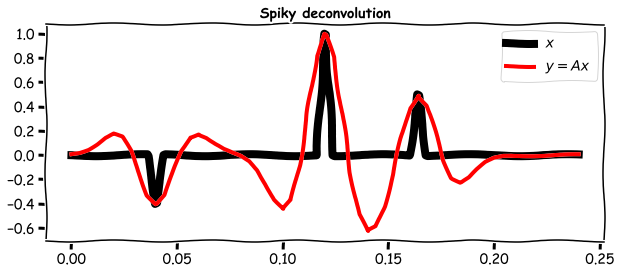

In [11]:
nt = 61
dt = 0.004
t = np.arange(nt) * dt
x = np.zeros(nt)
x[10] = -0.4
x[int(nt / 2)] = 1
x[nt - 20] = 0.5

h, th, hcenter = pylops.utils.wavelets.ricker(t[:101], f0=20)
Wop = pylops.signalprocessing.Convolve1D(nt, h=h, offset=hcenter, dtype="float32")
y = Wop * x

with plt.xkcd():
    fig, ax = plt.subplots(1, 1, figsize=(10, 4))
    ax.plot(t, x, "k", lw=8, label=r"$x$")
    ax.plot(t, y, "r", lw=4, label=r"$y=Ax$")
    ax.set_title("Spiky deconvolution", fontsize=14, fontweight="bold")
    ax.legend()



In [12]:
# Least-squares
xls = Wop / y

# L1-regularized
l1 = pyproximal.proximal.L1()
l2 = pyproximal.proximal.L2(Op=Wop, b=y)
L = np.abs((Wop.H * Wop).eigs(1)[0])
tau = 0.95/L
eps = 1e-1
niter = 1000

xista_err, xfista_err = [], []
xista = pyproximal.optimization.primal.ProximalGradient(
                l2, l1, tau=tau, 
                x0=np.zeros(nt), 
                epsg=eps, niter=niter, 
                callback=lambda xest: callback(xest, x, xista_err))
xfista = pyproximal.optimization.primal.AcceleratedProximalGradient(
                l2, l1, tau=tau, 
                x0=np.zeros(nt), acceleration='fista',
                epsg=eps, niter=niter, 
                callback=lambda xest: callback(xest, x, xfista_err))

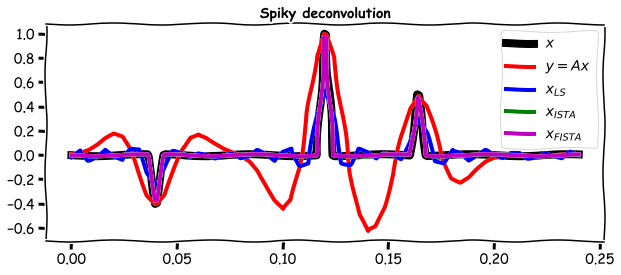

In [13]:
with plt.xkcd():
    fig, ax = plt.subplots(1, 1, figsize=(10, 4))
    ax.plot(t, x, "k", lw=8, label=r"$x$")
    ax.plot(t, y, "r", lw=4, label=r"$y=Ax$")
    ax.plot(t, xls, "b", lw=4, label=r"$x_{LS}$")
    ax.plot(t, xista, "g", lw=4, label=r"$x_{ISTA}$")
    ax.plot(t, xfista, "m", lw=4, label=r"$x_{FISTA}$")
    ax.set_title("Spiky deconvolution", fontsize=14, fontweight="bold")
    ax.legend()

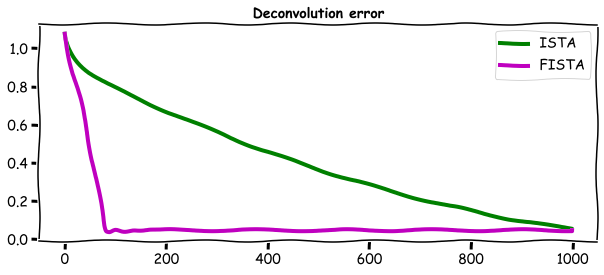

In [14]:
with plt.xkcd():
    fig, ax = plt.subplots(1, 1, figsize=(10, 4))
    ax.plot(xista_err, "g", lw=4, label="ISTA")
    ax.plot(xfista_err, "m", lw=4, label="FISTA")
    ax.set_title("Deconvolution error", fontsize=14, fontweight="bold")
    ax.legend()  

## Seismic interpolation

$$
\underset{\mathbf{x}} {\mathrm{argmin}} \quad \frac{1}{2} ||\mathbf{d} - \mathbf{RS^Hx}||_2^2 + \alpha ||\mathbf{x}||_1
$$

where $\mathbf{d}$ is a subsampled data, $\mathbf{R}$ is sampling operator and $\mathbf{S}$ is the sliding linear Radon operator (sparsifying transform). Here $\mathbf{m}=\mathbf{S^Hx}$ is the seismic data sampled along a finely, regular receiver array.

In [15]:
inputfile = 'Data/data.npz'
inputdata = np.load(inputfile, allow_pickle=True)

# Load data, time and space axes
x = inputdata['R'][50, :100, :-100]
x = x/np.abs(x).max()

taxis, xaxis = inputdata['t'][:-100], inputdata['r'][0][:100]
par = {}
nx, nt = x.shape
dx = inputdata['r'][0, 1] - inputdata['r'][0, 0]
dt = inputdata['t'][1] - inputdata['t'][0]

# Convolve data with wavelet
wav = inputdata['wav']
wav_c = np.argmax(wav)
x = np.apply_along_axis(convolve, 1, x, wav, mode='full')
x = x[:, wav_c:][:, :nt]

# Apply gain
gain = np.tile((taxis**2)[:, np.newaxis], (1, nx)).T
x *= gain

In [16]:
# Define subsampling locations
np.random.seed(10)
perc_subsampling = 0.5
nxsub = int(np.round(nx * perc_subsampling))
ixava = np.sort(np.random.permutation(np.arange(nx))[:nxsub])

# Create restriction operator
Rop = pylops.Restriction(nx * nt, ixava, dims=(nx, nt), dir=0, dtype=np.float64)

# Create data
y = Rop * x.ravel()
xadj = Rop.H * y.ravel()
y = y.reshape(nxsub, nt)
xadj = xadj.reshape(nx, nt)

In [17]:
# Apply mask
ymask = Rop.mask(x.ravel())

# FFT of full data
nfft = 2**10
FFTop = pylops.signalprocessing.FFT2D(dims=(nx, nt), nffts=(nfft, nfft), sampling=(dx, dt))
p = FFTop * x.ravel()
p = np.reshape(p, (nfft, nfft))

pmask = FFTop * ymask.flatten()
pmask = np.reshape(pmask, (nfft, nfft))

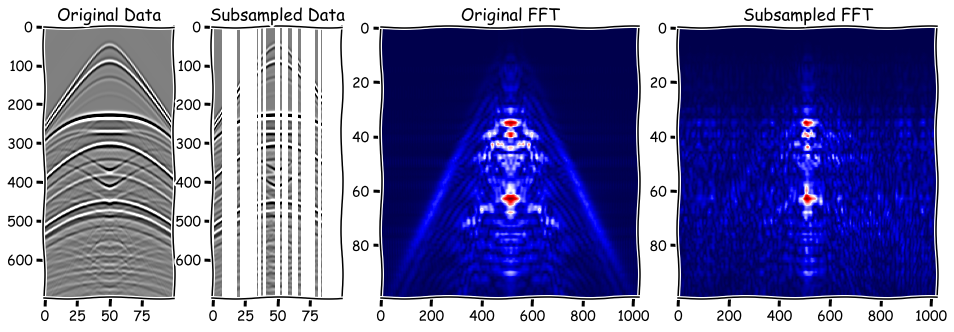

In [18]:
with plt.xkcd():
    fig, axs = plt.subplots(1, 4, figsize=(16, 5),
                            gridspec_kw={'width_ratios': [1, 1, 2, 2]})
    axs[0].imshow(x.T, cmap='gray', vmin=-0.05, vmax=0.05)
    axs[0].set_title('Original Data')
    axs[0].axis('tight')
    axs[1].imshow(ymask.T, cmap='gray', vmin=-0.05, vmax=0.05)
    axs[1].set_title('Subsampled Data')
    axs[1].axis('tight')
    axs[2].imshow(np.fft.fftshift(np.abs(p[:, :100]), axes=0).T, cmap='seismic')
    axs[2].set_title('Original FFT')
    axs[2].axis('tight')
    axs[3].imshow(np.fft.fftshift(np.abs(pmask[:, :100]), axes=0).T, cmap='seismic')
    axs[3].set_title('Subsampled FFT')
    axs[3].axis('tight')

In [19]:
# Sliding Radon operator
nwin = 20 # Size of slice in spatial direction
nwins = 9 # Number of slices
nover = 10 # Number of overlapping samples between windows
pxmax = 5e-4 # Max slowness

px = np.linspace(-pxmax, pxmax, nwin)
dimsd = x.shape
dims = (nwins*nwin, dimsd[1])
Op = pylops.signalprocessing.ChirpRadon2D(taxis, 
                                          np.linspace(-dx*nwin//2, dx*nwin//2, nwin), 
                                          pxmax * dx / dt).H
Slidop = pylops.signalprocessing.Sliding2D(Op, dims, dimsd, nwin, nover,
                                           tapertype='cosine', design=False)

In [20]:
# Inverse
Rop1 = Rop * Slidop
l1 = pyproximal.proximal.L1()
l2 = pyproximal.proximal.L2(Op=Rop1, b=y.ravel())
L = np.abs((Slidop.H * Slidop).eigs(1)[0])
tau = 0.95/L
eps = 5e-3
niter = 400
xinv = pyproximal.optimization.primal.AcceleratedProximalGradient(
                l2, l1, tau=tau, 
                x0=np.zeros(dims[0]*dims[1]), acceleration='fista',
                epsg=eps, niter=niter, show=False)
xinv = Slidop * xinv
xinv = xinv.reshape(nx, nt)

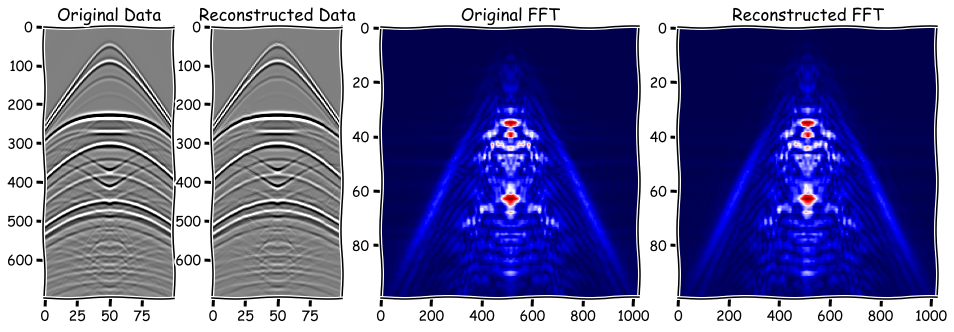

In [21]:
with plt.xkcd():
    pinv = FFTop * xinv.flatten()
    pinv = np.reshape(pinv, (nfft, nfft))
    
    fig, axs = plt.subplots(1, 4, figsize=(16, 5),
                            gridspec_kw={'width_ratios': [1, 1, 2, 2]})
    axs[0].imshow(x.T, cmap='gray', vmin=-0.05, vmax=0.05)
    axs[0].set_title('Original Data')
    axs[0].axis('tight')
    axs[1].imshow(xinv.T, cmap='gray', vmin=-0.05, vmax=0.05)
    axs[1].set_title('Reconstructed Data')
    axs[1].axis('tight')
    axs[2].imshow(np.fft.fftshift(np.abs(p[:, :100]), axes=0).T, cmap='seismic')
    axs[2].set_title('Original FFT')
    axs[2].axis('tight')
    axs[3].imshow(np.fft.fftshift(np.abs(pinv[:, :100]), axes=0).T, cmap='seismic')
    axs[3].set_title('Reconstructed FFT')
    axs[3].axis('tight');

## Optimizing mixed (smooth & non-smooth) functionals

When both where $f$ and $g$ are non-smooth, convex functions, the Proximal gradient algorithm (or ISTA) cannot be used.

In order to solve this problem, a two steps procedure is required:

- Splitting: $\mathbf{y}=\mathbf{m}$, such that

$$
\underset{\mathbf{m}, \mathbf{y}} {\mathrm{argmin}} \quad f(\mathbf{m}) + g(\mathbf{y})
$$

- Augmented Lagrangian: $\text{arg} \underset{\mathbf{m},\mathbf{y}} {\mathrm{min}} \underset{\mathbf{z}}  {\mathrm{max}} \mathscr{L}$, where 
$$
\mathscr{L}=f(\mathbf{m}) + g(\mathbf{y}) + \frac{\rho}{2}||\mathbf{m}-\mathbf{y}||_2^2 + \mathbf{z}^T(\mathbf{m}-\mathbf{y})
$$

- Alternating minimization:

$$
\mathbf{m}_k = \underset{\mathbf{m}} {\mathrm{argmin}} \quad \mathscr{L}(\mathbf{m}, \mathbf{y}_{k-1}, \mathbf{z}_{k-1}) = prox_{\tau f}(\mathbf{y}_{k-1}-\mathbf{z}_{k-1}) \\
\mathbf{y}_k = \underset{\mathbf{y}} {\mathrm{argmin}} \quad \mathscr{L}(\mathbf{m}_k, \mathbf{y}, \mathbf{z}_{k-1}) = prox_{\tau g}(\mathbf{m}_k+\mathbf{z}_{k-1}) \\
\mathbf{z}_k = \underset{\mathbf{z}} {\mathrm{argmax}} \quad \mathscr{L}(\mathbf{m}_k, \mathbf{y}_k, \mathbf{z}) = \mathbf{z}_{k-1} + \mathbf{m}_k - \mathbf{y}_k
$$

This is the famous **ADMM** algorithm.

## Optimizing mixed (smooth & non-smooth) functionals

Similarly, when we want a regularizer of the form $||\mathbf{Lm}||_p$:

$$
\text{arg} \underset{\mathbf{m}} {\mathrm{min}} \quad f(\mathbf{m}) + g(\mathbf{Lm})
$$

- Splitting: $\mathbf{y}=\mathbf{Lm}$
- Augmented Lagrangian: $\text{arg} \underset{\mathbf{m},\mathbf{y}} {\mathrm{min}} \underset{\mathbf{z}}  {\mathrm{max}} \mathscr{L}$, where 
$$
\mathscr{L}=f(\mathbf{m}) + g(\mathbf{y}) + \frac{\rho}{2}||\mathbf{Lm}-\mathbf{y}||_2^2 + \mathbf{z}^T(\mathbf{Lm}-\mathbf{y})
$$

## Optimizing mixed (smooth & non-smooth) functionals

- Alternating minimization:

$$
\mathbf{m}_k = \underset{\mathbf{m}} {\mathrm{argmin}} \quad \mathscr{L}(\mathbf{m}, \mathbf{y}_{k-1}, \mathbf{z}_{k-1}) \\
\mathbf{y}_k = \underset{\mathbf{y}} {\mathrm{argmin}} \quad \mathscr{L}(\mathbf{m}_k, \mathbf{y}, \mathbf{z}_{k-1}) = prox_{\tau g}(\mathbf{Lm}_{k} + \mathbf{z}_{k-1}) \\ \\
\mathbf{z}_k = \underset{\mathbf{z}} {\mathrm{argmax}} \quad \mathscr{L}(\mathbf{m}_k, \mathbf{y}_k, \mathbf{z}) = \mathbf{z}_{k-1} + \mathbf{Lm}_k - \mathbf{y}_k
$$

## ADMM for L2-L1 functionals

Let's now consider a special case where

$$
\underset{\mathbf{m}} {\mathrm{argmin}} \quad \frac{1}{2} ||\mathbf{d} - \mathbf{Gm}||_2^2 + \alpha ||\mathbf{Lm}||_1
$$

This reduces to:

$$
\mathbf{m}_k = (\mathbf{G}^H \mathbf{G} + \rho \mathbf{L}^H \mathbf{L})^{-1} (\mathbf{G}^H \mathbf{d} +  \rho \mathbf{L}^H(\mathbf{y}_{k-1} - \mathbf{z}_{k-1})) \\
\mathbf{y}_k = soft(\mathbf{Lm}_{k} + \mathbf{z}_{k-1}, \alpha / \rho) \\ \\
\mathbf{z}_k = \mathbf{z}_{k-1} + \mathbf{Lm}_k - \mathbf{y}_k
$$


## ADMM for L2-L1 functionals

Note that the first step is the proximal operator of the L2 squared norm of the following system of equations:

$$
\begin{bmatrix} 
\mathbf{G} \\
\sqrt{ \rho}\mathbf{L}
  \end{bmatrix} \mathbf{m} = 
\begin{bmatrix} 
\mathbf{d} \\
\sqrt{ \rho}(\mathbf{y}_{k-1} - \mathbf{z}_{k-1})
  \end{bmatrix}
$$

and can be solved directly or via any of the iterative scheme for least-squares inversion (e.g., CGLS, LSQR).



## Total-variation regularized inversion

$$
\underset{\mathbf{m}} {\mathrm{argmin}} \quad \frac{1}{2} ||\mathbf{d} - \mathbf{Gm}||_2^2 + \alpha TV(\mathbf{m}) \qquad \textrm{TV-regularized inversion}
$$

This can be seen as a special case of ADMM for L2-L1 functionals, as the isotropic TV is the $L_{2,1}$ norm of the gradients of $\mathbf{m}$.

**Problem 1**: Seismic-Post stack inversion ($\mathbf{G}$ is the convolutional modelling operator, $\mathbf{m}$ is the acoustic impedance model) - from Ravasi and Birnie, 2021.

**Problem 2**: MRI Imaging ($\mathbf{G}$ is the restricted 2D-FFT operator, $\mathbf{m}$ is an anatomical image)  - from Corona et al., 2021.

In [22]:
# Raw model
f = segyio.open('Data/timodel_vp.segy', ignore_geometry=True)
v = segyio.collect(f.trace[:]).T 
vmin, vmax = np.min(v), np.max(v)

In [23]:
# Base model
vpad = np.pad(v, ((80, 0), (0, 0)), constant_values=v[0, 0])
vpad = vpad[::8, ::8]

nt0, nx = vpad.shape
dt0 = 0.008
t0  = np.arange(nt0)*dt0
dx  = 4
x   = np.arange(nx)*dx

rho = 2000.
m  = np.log(vpad*rho) # Depth was converted to m

In [24]:
# Wavelet
ntwav = 61
wav, twav, wavc = pylops.utils.wavelets.ricker(t0[:ntwav//2+1], 8)

# Operator
Lop = pylops.avo.poststack.PoststackLinearModelling(wav / 2, nt0=nt0, spatdims=nx)


# Smooth model
nsmooth = 30
mback = filtfilt(np.ones(nsmooth)/float(nsmooth), 1,
                 filtfilt(np.ones(nsmooth)/float(nsmooth), 1, m, axis=0), axis=1)


# Data
d = Lop * m.ravel()

sigman = 1e-1
n = filtfilt(np.ones(10)/10, 1,
             filtfilt(np.ones(5)/5, 1, np.random.normal(0, sigman, (nt0, nx)).T, method='gust').T,
             method='gust').ravel()
dn = d + n
dn = dn.reshape(nt0, nx)

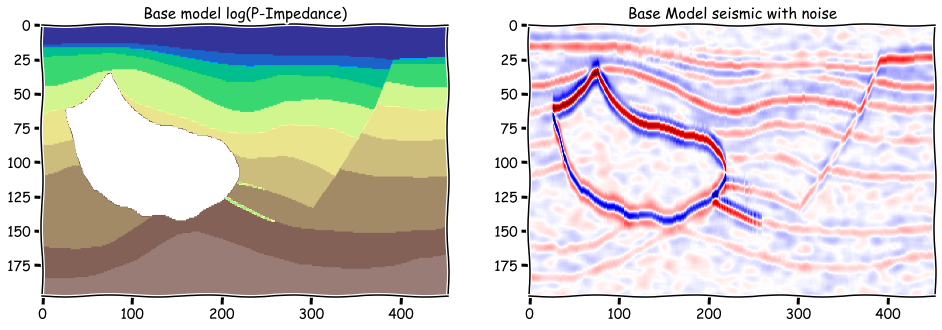

In [25]:
with plt.xkcd():
    fig, ax = plt.subplots(1, 2, figsize=(16,5))

    ax[0].imshow(m, cmap='terrain')
    ax[0].axis('tight')
    ax[0].set_title('Base model log(P-Impedance)', fontsize=15)
    ax[1].imshow(dn, vmin=-0.3, vmax=0.3, cmap='seismic')
    ax[1].set_title('Base Model seismic with noise', fontsize=15)
    ax[1].axis('tight');

In [26]:
# L2-reg inversion
Dop = pylops.Laplacian(dims=(nt0, nx), dtype=Lop.dtype)
ml2 = pylops.optimization.leastsquares.RegularizedInversion(Lop, [Dop], dn.ravel(),
                                                            x0=mback.ravel(), 
                                                            epsRs=[0.0005], 
                                                            returninfo=False, 
                                                            show=False,
                                                            **dict(iter_lim=100, 
                                                                   damp=0.5))
ml2 = ml2.reshape(nt0, nx)

# TV-reg inversion
sigma = 0.02
l2_2 = pyproximal.proximal.L2(Op=Lop, b=dn.ravel(), niter=20, warm=True)
Dop = pylops.Gradient(dims=(nt0, nx), edge=True, dtype=Lop.dtype, kind='forward')
l21 = pyproximal.proximal.L21(ndim=2, sigma=sigma)

L = 8.
tau = 1.
mu = 0.99 / (tau * L)
mpd = pyproximal.optimization.primal.LinearizedADMM(l2_2, l21, Dop, mback.ravel(), 
                                                    tau=tau, mu=mu, 
                                                    niter=100, show=False)[0]
mpd = mpd.reshape(nt0, nx)

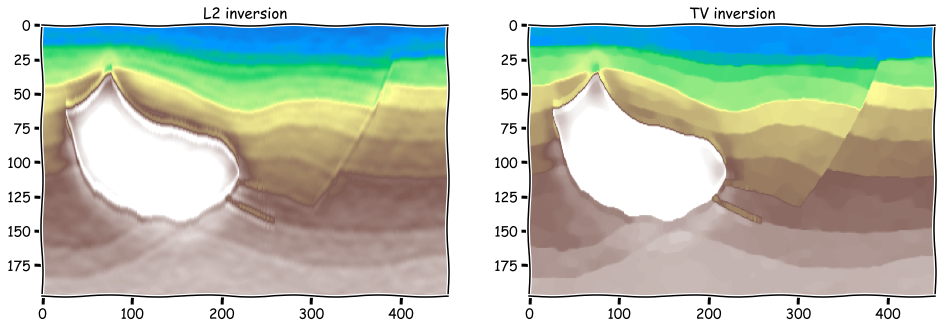

In [27]:
with plt.xkcd():
    fig, ax = plt.subplots(1, 2, figsize=(16,5))

    ax[0].imshow(ml2, cmap='terrain', vmin=16, vmax=17.1)
    ax[0].axis('tight')
    ax[0].set_title('L2 inversion', fontsize=15)
    ax[1].imshow(mpd, cmap='terrain', vmin=16, vmax=17.1)
    ax[1].set_title('TV inversion', fontsize=15)
    ax[1].axis('tight');

In [28]:
def RRE(x, xinv):
    return np.linalg.norm(x-xinv) / np.linalg.norm(x)

def PSNR(x, xinv):
    return 10 * np.log10(len(xinv) * np.max(xinv) / np.linalg.norm(x-xinv))

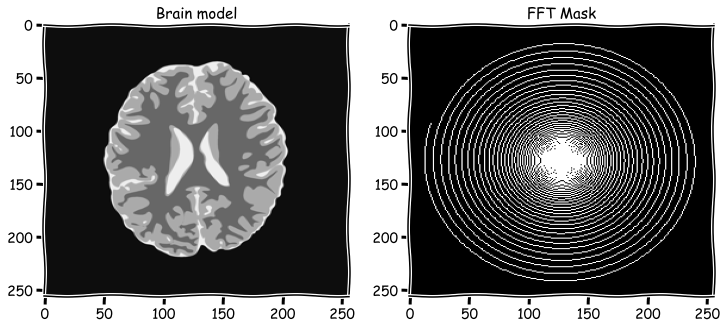

In [29]:
brain = loadmat('Data/brainphantom.mat')
mask = loadmat('Data/spiralsampling.mat')

brain = brain['gt']
mask = mask['samp']
mask_fft = np.fft.ifftshift(mask)

with plt.xkcd():
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))
    ax[0].imshow(brain, cmap='gray')
    ax[0].axis('tight')
    ax[0].set_title('Brain model', fontsize=15)
    ax[1].imshow(mask, cmap='gray')
    ax[1].set_title('FFT Mask', fontsize=15)
    ax[1].axis('tight');

In [30]:
# Reconstruction operator
Fop = pylops.signalprocessing.FFT2D(dims=brain.shape)
Rop = pylops.Restriction(brain.size, np.where(mask_fft.ravel() == 1)[0], dtype=np.complex)
Dop = Rop * Fop

# Data
sigman = 0.
brain_fft = Fop * brain.ravel()
brain_fft = brain_fft.reshape(brain.shape)
d = Dop * brain.ravel()
d += np.random.normal(0, sigman, d.shape)

In [31]:
# Zero-filling reconstruction
brain_zero = mask_fft * brain_fft
brain_zero = Fop.H * brain_zero.ravel()
brain_zero = np.real(brain_zero.reshape(brain.shape))

In [32]:
# TV reconstruction
sigma = 0.04
l1 = pyproximal.proximal.L21(ndim=2, sigma=sigma)
l2 = pyproximal.proximal.L2(Op=Dop, b=d.ravel(), niter=50, warm=True)
Gop = pylops.Gradient(dims=brain.shape, edge=True, kind='forward', dtype=np.complex)

L = 8
tau = .99 / np.sqrt(L)
mu = .99 / np.sqrt(L)
brain_tv = pyproximal.optimization.primaldual.PrimalDual(l2, l1, Gop, 
                                                         x0=np.zeros(brain.size), 
                                                         tau=tau, mu=mu, theta=1., 
                                                         niter=100, show=False)
brain_tv = np.real(brain_tv.reshape(brain.shape))

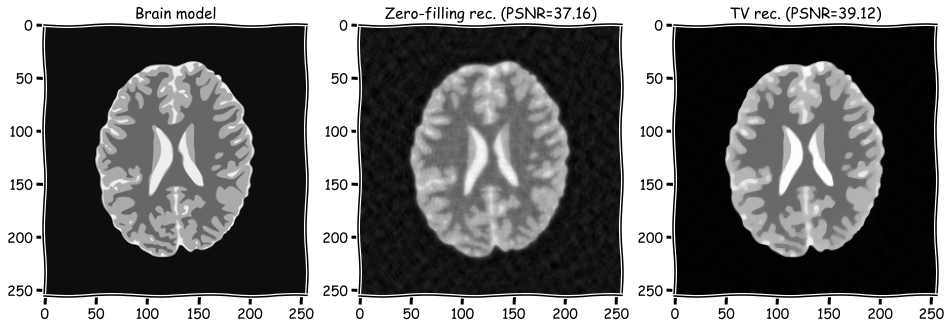

In [33]:
with plt.xkcd():
    fig, ax = plt.subplots(1, 3, figsize=(16, 5))
    ax[0].imshow(brain, cmap='gray')
    ax[0].axis('tight')
    ax[0].set_title('Brain model', fontsize=15)
    ax[1].imshow(brain_zero, cmap='gray')
    ax[1].set_title('Zero-filling rec. (PSNR=%.2f)' % PSNR(brain.ravel(), 
                                                           brain_zero.ravel()), 
                    fontsize=15)
    ax[1].axis('tight')
    ax[2].imshow(brain_tv, cmap='gray')
    ax[2].set_title('TV rec. (PSNR=%.2f)' % PSNR(brain.ravel(), 
                                                 brain_tv.ravel()), 
                    fontsize=15)
    ax[2].axis('tight');

## Nonlinear constrained inversion

The algorithms that we have discussed up until now can be easily extended to nonlinear problems. Consider:

$$
\underset{\mathbf{x}} {\mathrm{argmin}} \quad f(\mathbf{x}) \quad s.t. \quad \mathbf{x}
        \in I_{Box}
$$

The Proximal gradient algorithm simply becomes:

$$
\mathbf{m}_{k+1} = prox_{\delta I_{Box}} (\mathbf{x}_k - \nabla f(\mathbf{x}_k))\\
$$

In [34]:
def rosenbrock(x, y, a=1, b=10):
    f = (a - x)**2 + b*(y - x**2)**2
    return f

def rosenbrock_grad(x, y, a=1, b=10):
    dfx = -2*(a - x) - 2*b*(y - x**2) * 2 * x
    dfy = 2*b*(y - x**2)
    return dfx, dfy

def contour_rosenbrock(x, y):
    fig, ax = plt.subplots(figsize=(12, 6))

    # Evaluate the function
    x, y = np.meshgrid(x, y)
    z = rosenbrock(x, y)

    # Plot the surface.
    surf = ax.contour(x, y, z, 200, cmap='gist_heat_r', vmin=-20, vmax=200,
                      antialiased=False)
    fig.colorbar(surf, shrink=0.5, aspect=10)
    return fig, ax

class Rosebrock(pyproximal.proximal.Nonlinear):
    def setup(self, a=1, b=10, alpha=1.):
        self.a, self.b = a, b
        self.alpha = alpha
    def fun(self, x):
        return np.array(rosenbrock(x[0], x[1], a=self.a, b=self.b))
    def grad(self, x):
        return np.array(rosenbrock_grad(x[0], x[1], a=self.a, b=self.b))
    def optimize(self):
        self.solhist = []
        sol = self.x0.copy()
        for iiter in range(self.niter):
            x1, x2 = sol
            dfx1, dfx2 = self._gradprox(sol, self.tau)
            x1 -= self.alpha * dfx1
            x2 -= self.alpha * dfx2
            sol = np.array([x1, x2])
            self.solhist.append(sol)
        self.solhist = np.array(self.solhist)
        return sol
    
# Box constraint for plotting
xbound = np.arange(-1.5, 1.5, 0.01)
ybound = np.arange(-0.5, 1.5, 0.01)
X, Y = np.meshgrid(xbound, ybound, indexing='ij')
xygrid = np.vstack((X.ravel(), Y.ravel()))

In [35]:
# Standard nonlinear inversion
niters = 500
alpha = 0.02

steps = [(0, 0), ]
for iiter in range(niters):
    x, y = steps[-1]
    dfx, dfy = rosenbrock_grad(x, y)
    x -= alpha * dfx
    y -= alpha * dfy
    steps.append((x, y))
steps = np.array(steps)
x = np.arange(-1.5, 1.5, 0.15)
y = np.arange(-0.5, 1.5, 0.15)
nx, ny = len(x), len(y)

In [36]:
def callback(x):
    xhist.append(x)

In [37]:
# Box constraint
lower = 0.6
upper = 1.2
indic = (xygrid > lower) & (xygrid < upper)
indic = indic[0].reshape(xbound.size, ybound.size) & \
        indic[1].reshape(xbound.size, ybound.size)

# Proximal gradient
fnl = Rosebrock(niter=20, x0=np.zeros(2), warm=True)
fnl.setup(1, 10, alpha=0.02) # alpha=step-size
ind = pyproximal.proximal.Box(lower, upper)

x0 = np.array([0, 0])
xhist = [x0,]
xinv_pg = pyproximal.optimization.primal.ProximalGradient(fnl, ind,
                                                          tau=0.001,
                                                          x0=x0, epsg=1.,
                                                          niter=5000, show=False,
                                                          callback=callback)
xhist_pg = np.array(xhist)

In [38]:
# ADMM
x0 = np.array([0, 0])

xhist = [x0,]
xinv_admm = pyproximal.optimization.primal.ADMM(fnl, ind,
                                                tau=1.,
                                                x0=x0,
                                                niter=30, show=False,
                                                callback=callback)
xhist_admm = np.array(xhist)

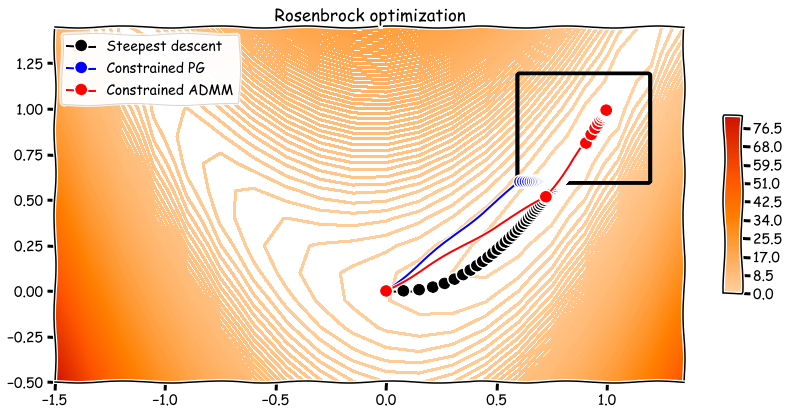

In [39]:
with plt.xkcd():
    fig, ax = contour_rosenbrock(x, y)
    ax.contour(X, Y, indic, colors='k')
    ax.plot(steps[::2, 0], steps[::2, 1], '.-k', ms=20, label='Steepest descent')
    ax.plot(xhist_pg[::2, 0], xhist_pg[::2, 1], '.-b', ms=20, label='Constrained PG')
    ax.plot(xhist_admm[::2, 0], xhist_admm[::2, 1], '.-r', ms=20, label='Constrained ADMM')
    ax.set_title('Rosenbrock optimization')
    ax.legend(loc='upper left')
    ax.set_xlim(x[0], x[-1])
    ax.set_ylim(y[0], y[-1])
    fig.tight_layout()

## Other interesting problems

- A Joint Inversion-Segmentation approach to Assisted Seismic Interpretation - Ravasi and Birnie ([paper](https://academic.oup.com/gji/article/228/2/893/6374557?login=true), [code](https://github.com/dig-kaust/htracker))

$$
\underset{\mathbf{m}, \mathbf{V} \in C} {\mathrm{argmin}} \quad \frac{1}{2} ||\mathbf{d} - \mathbf{Gm}||_2^2 + \alpha TV(\mathbf{m})  + \delta \sum_{j=1}^{N_c} \sum_{i=1}^{N_x N_z}  V_{ji} (m_i - c_j)^2 +\beta \sum_{j=1}^{N_c}TV(\mathbf{V}^T_j)
$$

<img src="Figs/JointInvSeg.png" width="800" align="center">

## Other interesting problems

- Robust Joint Inversion and Segmentation of 4D Seismic Data - Romero, Ravasi, Luiken, submitted to SEG 2022

$$
\underset{\mathbf{m}, \mathbf{V} \in C} {\mathrm{argmin}} \quad \frac{1}{2} ||\mathbf{d}_{b,m} - \mathbf{G}_{b,m} \mathbf{m}_{b,m}||_2^2 + \alpha \sum_{i=\{b,m\}}TV(\mathbf{m}_i)  + \delta \sum_{j=1}^{N_c} \sum_{i=1}^{N_x N_z}  V_{ji} ((m_{i,m} - m_{i,b}) - c_j)^2 +\beta \sum_{j=1}^{N_c}TV(\mathbf{V}^T_j)
$$

<img src="Figs/4DInv.png" width="800" align="center">

## Other interesting problems

- Deblending by inversion using a self-supervised denoiser - Luiken and Ravasi, submitted to EAGE 2022

$$
\underset{\mathbf{x}} {\mathrm{argmin}}  \Vert \Phi^{H}\mathbf{b} - \mathbf{S}^H\mathbf{x}\Vert_1 + \lambda\Vert \mathbf{x}\Vert_1,
$$

<img src="Figs/L1L1Denoising.png" width="700" align="center">


## Other interesting problems

- Robust regularized regression using a modified ADMM - Luiken and Ravasi, submitted to SEG 2022

$$
\underset{\mathbf{x}} {\mathrm{argmin}}  \Vert \mathbf{d} - \Phi\mathbf{x} ||_2^2 +  \lambda \mathscr{R}(\mathbf{x}),
$$

where $\mathscr{R}$ is any denoiser - this is called Plug-and-Play prior!

Stay tuned... Nick's presentation in the next IICU seminar ☺️

## That's it for today!!
### ... check out the [PyProximal](http://pyproximal.readthedocs.io) package for more fun with proximal solvers